In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd

cudnn.benachmark = True

In [212]:
DATA_PATH = r"CaptchaDateien"
test_size = 0.15
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
# Load data

In [3]:
image_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, r'train_val'))


In [4]:
image_dataset[0]

(<PIL.Image.Image image mode=RGB size=120x120>, 0)

In [29]:
# View targets and distribution

In [30]:
image_dataset.class_to_idx

{'Bicycle': 0,
 'Bridge': 1,
 'Bus': 2,
 'Car': 3,
 'Chimney': 4,
 'Crosswalk': 5,
 'Hydrant': 6,
 'Motorcycle': 7,
 'Other': 8,
 'Palm': 9,
 'Stair': 10,
 'Traffic Light': 11}

In [31]:
targets = image_dataset.targets

In [84]:
target_arr = np.array(targets)
target_distribution = np.unique(target_arr, return_counts=True)
target_distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([200, 136, 309, 910,  32, 317, 243,  21, 343, 233,  54, 202],
       dtype=int64))

In [ ]:
# Load Test

In [ ]:
image_testset = datasets.ImageFolder(os.path.join(DATA_PATH, r'test'))


In [34]:
# Train and validation split

In [41]:
train_indices, val_indices, _, _ = train_test_split(
    range(len(image_dataset)),
    image_dataset.targets,
    test_size=test_size,
    random_state=10,
    stratify=image_dataset.targets
)

In [95]:
len(train_indices)

2550

In [96]:
len(val_indices)

450

In [227]:
train_dataset = torch.utils.data.Subset(image_dataset, train_indices)
validation_dataset = torch.utils.data.Subset(image_dataset, val_indices)
dataset_sizes = {'train': len(train_dataset), 'val': len(validation_dataset)}

In [99]:
assert len(train_dataset) == (1-test_size)*len(image_dataset)
assert len(validation_dataset) == test_size*len(image_dataset)
assert len(train_indices) + len(val_indices) == len(image_dataset)

In [86]:
# check class distributions

In [101]:
train_distribution =  {}
validation_distribution = {}

In [102]:
for x in train_dataset: 
    try:
        train_distribution[x[1]] = train_distribution[x[1]] + 1
    except:
        train_distribution[x[1]]= 1

for x in validation_dataset:
    try:
        validation_distribution[x[1]] = validation_distribution[x[1]] + 1
    except: 
        validation_distribution[x[1]] = 1

sorted_train_dist = sorted(list(train_distribution.items()))
sorted_val_dist = sorted(list(validation_distribution.items()))

In [103]:
train_distribution = (np.array([x[0] for x in sorted_train_dist]), np.array([x[1] for x in sorted_train_dist]))
val_distribution = (np.array([x[0] for x in sorted_val_dist]), np.array(np.array([x[1] for x in sorted_val_dist])))

In [104]:
train_distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([170, 116, 263, 773,  27, 269, 207,  18, 291, 198,  46, 172]))

In [105]:
val_distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 30,  20,  46, 137,   5,  48,  36,   3,  52,  35,   8,  30]))

In [109]:
assert np.array_equal(np.array([x for x in train_distribution[1]]) + np.array([x for x in val_distribution[1]]), target_distribution[1])

In [123]:
class ApplyTransform(Dataset): 
    """Apply transformations to each item in the dataset

    :param Dataset: Extends Dataset
    :type Dataset: Dataset
    """

    def __init__(self, dataset, transform = None, target_transform = None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, idx): 
        sample, target = self.dataset[idx]
        if self.transform is not None: 
            sample = self.transform(sample)
        if self.target_transform is not None: 
            target = self.target_transform(target)
        return sample, target
    
    def __len__(self): 
        return len(self.dataset)

In [124]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [125]:
validation_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [126]:
data_sets = (ApplyTransform(train_dataset, train_transform), ApplyTransform(validation_dataset, validation_transform))
names = ("train", "validation")

In [127]:
dataloaders = {names[x]: torch.utils.data.DataLoader(data_sets[x], batch_size=8,shuffle=True) for x in range(2)}

In [160]:
# Visualize one batch

In [156]:
tf, tl = next(iter(dataloaders["train"]))

In [151]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None: 
        plt.title(title)
    plt.pause(0.001)

In [157]:
tf.shape

torch.Size([8, 3, 224, 224])

In [206]:
out = torchvision.utils.make_grid(tf, nrow=4, padding=0)

In [207]:
out.shape

torch.Size([3, 448, 896])

In [208]:
tf.shape

torch.Size([8, 3, 224, 224])

In [209]:
tl

tensor([11,  9,  1,  3,  6, 11,  3,  3])

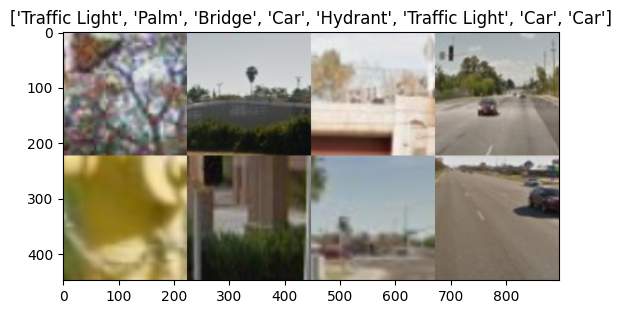

In [210]:
imshow(out, title=[image_dataset.classes[x] for x in tl])

In [172]:
np.clip(out.numpy().transpose((1,2,0)), 0,1).shape

(454, 906, 3)

In [221]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    print(outputs)
                    print(labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [214]:
model_ft = models.resnet18(pretrained=True)


c:\Users\ricke\Desktop\Python_Bonus\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ricke\Desktop\Python_Bonus\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ricke/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [215]:
num_ftrs = model_ft.fc.in_features

In [223]:
model_ft.fc = nn.Linear(num_ftrs, 12)
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [224]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [225]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [226]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
tensor([[ 0.3876, -0.7601,  0.0928, -0.1528, -0.8326,  0.8141, -0.2955, -0.3848,
         -0.6457, -0.8314, -0.6235,  0.1624],
        [-0.1835, -0.7599, -0.3353,  0.3413, -0.4131,  0.7968, -0.3257, -0.4806,
         -0.3421,  0.2100,  0.2160,  0.0739],
        [-0.7833, -0.6721, -0.2029, -0.4272,  0.1825,  0.4167, -0.0209, -0.2646,
         -1.3013, -0.8554,  0.0307,  0.2308],
        [ 0.4715, -0.9588, -0.4908, -0.0754, -0.8686,  1.0189, -0.0609,  0.0910,
         -0.7409,  0.1100, -0.3691, -0.4511],
        [ 0.0943, -0.9564, -0.1846,  0.0262,  0.4215, -0.2087,  1.4304, -0.1867,
         -0.2239, -0.0537, -0.0258, -0.1081],
        [ 0.4661, -0.3474, -0.4615,  0.2137, -0.7289,  0.4289, -0.3295, -0.0359,
         -1.1517,  0.1030, -0.1539, -0.0241],
        [-0.4096, -0.6363, -0.2772,  0.1512, -0.6508,  0.3838,  0.2119,  0.0175,
         -1.3818, -1.0106, -0.0712, -1.0196],
        [-0.0609, -0.1134,  0.0673,  0.8141, -0.6050,  0.1558,  0.2070, -0.4852,
        

KeyboardInterrupt: 